<a href="https://colab.research.google.com/github/kelseyneis/horoscope-mining/blob/main/exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI 5523 Final project
Mohammed Guiga, Kelsey Neis, Sai Sharan Sundar, Josh Spitzer-Resnick

## imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for reading csv in Colab
# from google.colab import files
# uploaded = files.upload() # if first time uncomment this and manually load in data # use chrome not firefox, not incognito
# import io

# exploratory analysis
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet') # get_lemmas
nltk.download('punkt') # nltk.word_tokenize in get_lemmas

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# If wordcloud has errors, run these lines and restart the kernel
# !pip install --upgrade pip
# !pip install --upgrade wordcloud

In [4]:
# df = pd.read_csv( io.BytesIO(uploaded['horoscope_saved.csv']) ) # nrows = 100. Use with Google Colab
df = pd.read_csv("../horoscope_saved.csv")
# horoscopes = np.genfromtxt(io.BytesIO(uploaded['horoscope_saved.csv']), delimiter = ',', max_rows = 100)

## exploratory data analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21959 entries, 0 to 21958
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sign       21959 non-null  object
 1   category   21959 non-null  object
 2   date       21959 non-null  int64 
 3   horoscope  21959 non-null  object
dtypes: int64(1), object(3)
memory usage: 686.3+ KB


In [6]:
df['sign'].unique()

array(['aries', 'taurus', 'gemini', 'cancer', 'leo', 'virgo', 'libra',
       'scorpio', 'sagittarius', 'capricorn', 'aquarius', 'pisces'],
      dtype=object)

In [7]:
df['category'].unique()

array(['general', 'love', 'career', 'wellness', 'birthday'], dtype=object)

### duplicates

In [8]:
df[df.duplicated()].count()

sign         0
category     0
date         0
horoscope    0
dtype: int64

In [9]:
# 9909 duplicated horoscope texts
df[['horoscope']][ df[['horoscope']].duplicated() ].count()

horoscope    9909
dtype: int64

In [10]:
# categories stay constant with duplicated horoscopes, still 9909
df[['horoscope', 'category']][ df[['horoscope', 'category']].duplicated() ].count()

horoscope    9909
category     9909
dtype: int64

In [11]:
# 109 duplicated horoscopes for the same sign, different date
df[['horoscope', 'sign']][ df[['horoscope', 'sign']].duplicated() ].count()

horoscope    109
sign         109
dtype: int64

### length of horoscopes

In [12]:
df['length'] = df['horoscope'].apply(len)

In [13]:
print(f"Maximum length of horoscope is {max(df['length'])}")
print(f"Minimim length of horoscope is {min(df['length'])}")

Maximum length of horoscope is 952
Minimim length of horoscope is 189


Text(0, 0.5, 'Frequency')

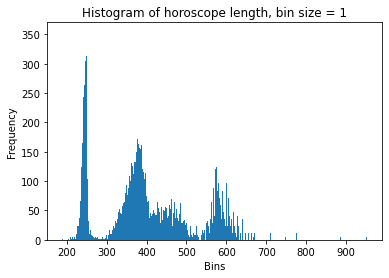

In [14]:
data = list(df['length'])
binsize = 1 # 30
plt.hist(data, bins=range(min(data), max(data) + binsize, binsize))

plt.title('Histogram of horoscope length, bin size = 1')
plt.xlabel("Bins")
plt.ylabel("Frequency")

array([[<AxesSubplot:title={'center':'aquarius'}>,
        <AxesSubplot:title={'center':'aries'}>,
        <AxesSubplot:title={'center':'cancer'}>],
       [<AxesSubplot:title={'center':'capricorn'}>,
        <AxesSubplot:title={'center':'gemini'}>,
        <AxesSubplot:title={'center':'leo'}>],
       [<AxesSubplot:title={'center':'libra'}>,
        <AxesSubplot:title={'center':'pisces'}>,
        <AxesSubplot:title={'center':'sagittarius'}>],
       [<AxesSubplot:title={'center':'scorpio'}>,
        <AxesSubplot:title={'center':'taurus'}>,
        <AxesSubplot:title={'center':'virgo'}>]], dtype=object)

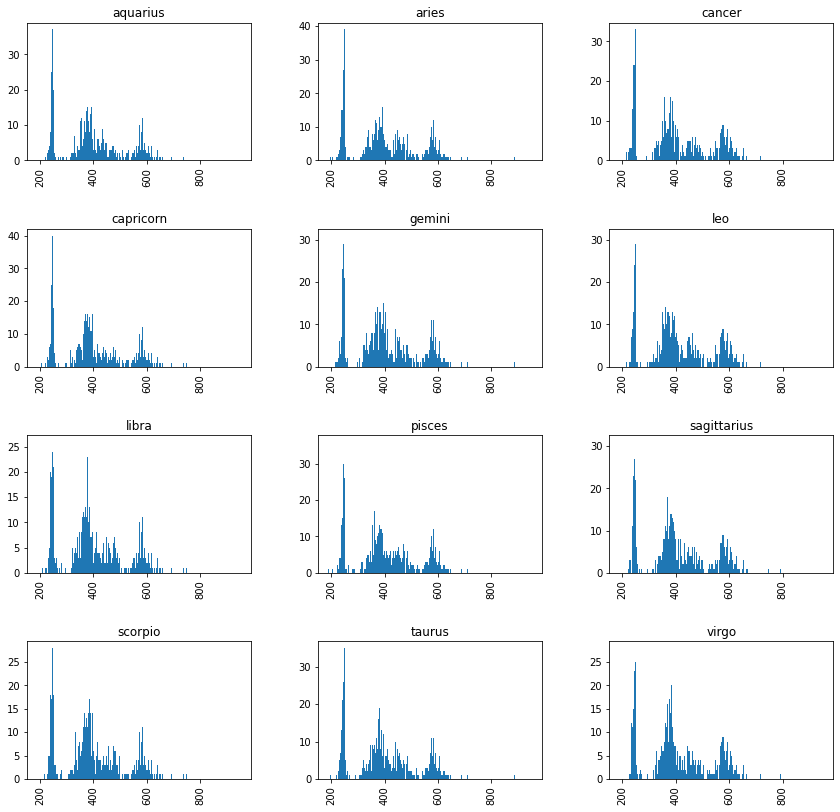

In [15]:
# doesn't change much by sign
binsize = 1
df.hist(column='length', by='sign', bins=range(min(data), max(data) + binsize, binsize),figsize=(14,14))

array([[<AxesSubplot:title={'center':'birthday'}>,
        <AxesSubplot:title={'center':'career'}>],
       [<AxesSubplot:title={'center':'general'}>,
        <AxesSubplot:title={'center':'love'}>],
       [<AxesSubplot:title={'center':'wellness'}>, <AxesSubplot:>]],
      dtype=object)

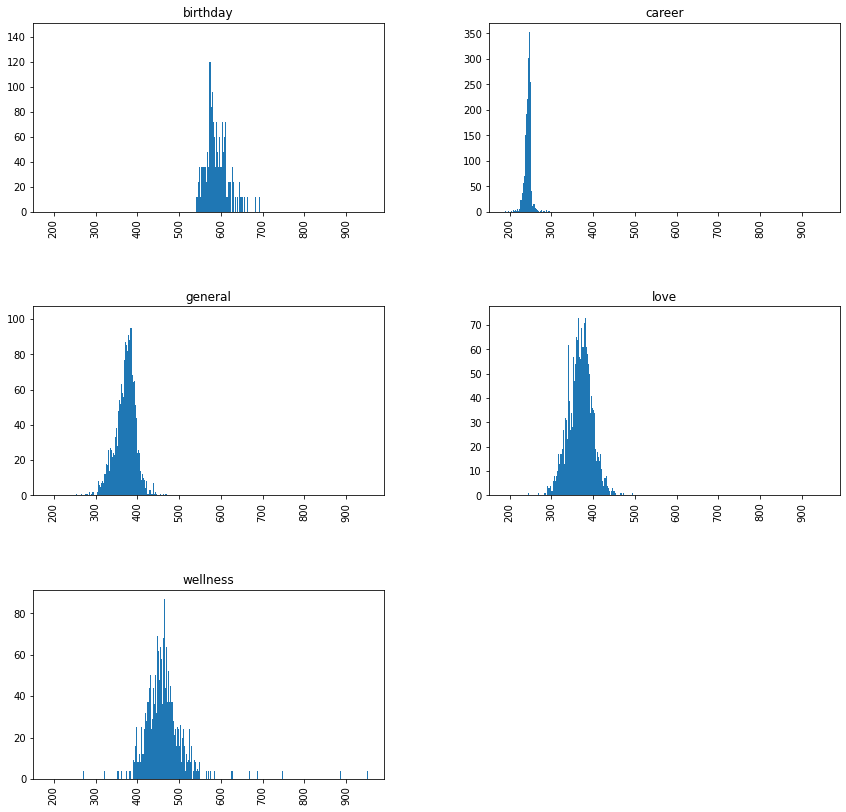

In [16]:
# does change significantly by category: career < general = love < wellness < birthday
binsize = 1
df.hist(column='length', by='category', bins=range(min(data), max(data) + binsize, binsize),figsize=(14,14))

### word count visualizations

In [17]:
# lists
signs = ['aries', 'taurus', 'gemini', 'cancer', 'leo', 'virgo', 'libra',
       'scorpio', 'sagittarius', 'capricorn', 'aquarius', 'pisces']
categories = ['general', 'love', 'career', 'wellness', 'birthday']
elements = ['fire', 'earth', 'air', 'water']
fire = ['aries', 'leo', 'sagittarius']
earth = ['taurus', 'virgo', 'capricorn']
air = ['gemini', 'libra', 'aquarius']
water = ['cancer', 'scorpio', 'pisces']
months = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']

words_to_remove = []
words_to_remove.extend(signs)
words_to_remove.extend(months)

all_horoscopes = df['horoscope']
# all_unique_horoscopes

all_general = df[df['category'] == 'general']['horoscope']
all_love = df[df['category'] == 'love']['horoscope']
all_career = df[df['category'] == 'career']['horoscope']
all_wellness = df[df['category'] == 'wellness']['horoscope']
all_birthday = df[df['category'] == 'birthday']['horoscope'] # wordcloud gives 2 grams for birthday, sometimes for love

In [18]:
horoscopes = all_wellness # change here so code below consistent

In [19]:
# remove punctuation
def remove_punctuation(text):
  no_punct = "".join([c for c in text if c not in string.punctuation])
  return no_punct

# tokenize horoscopes
tokenizer = RegexpTokenizer(r'\w+')

"""
# helper for get_lemmas
def get_wordnet_pos(word): # from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
"""

# Init the Wordnet Lemmatizer # adapted from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
lemmatizer = WordNetLemmatizer()
def get_lemmas(text): # needs sentence input, not list of words
  # lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in text]) # ' '.join([lemmatizer.lemmatize(w) for w in word_list])
  lemmatized_output = [lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text)] # [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
  """
  lem = []
  for w in text:
    lem.append([wi for wi in map(lemmatizer.lemmatize, w)]) # adapted from https://stackoverflow.com/questions/52860350/how-to-find-the-lemmas-and-frequency-count-of-each-word-in-list-of-sentences-in
  """
  return lemmatized_output # lem
  # [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)]

# remove stopwords
def remove_stopwords(text):
  words = [w for w in text if w not in stopwords.words('english')]
  return words

# remove sign indicators
def remove_sign_indicators(text):
  doc = [value for value in text if value not in words_to_remove]
  return doc

In [20]:
def preprocess(df):
  df = df.apply(lambda x: remove_punctuation(x))
  # df = df.apply(lambda x: tokenizer.tokenize(x.lower()))
  df = df.apply(lambda x: x.lower())
  
  # df = df.apply(lambda x: lemmatizer.lemmatize(x)) # needs text, not list
  # Make tokens a string again
  # df = [' '.join(map(str, l)) for l in df] # adapted from https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2
  df = df.apply(lambda x: get_lemmas(x)) # ''.join(x)) # takes much longer # don't tokenize before lemmatize?
  
  df = df.apply(lambda x: remove_stopwords(x)) # takes longer

  df = df.apply(lambda x: remove_sign_indicators(x))
  return df

In [21]:
tokens = preprocess(horoscopes) # takes ~3min on all_horoscopes

In [22]:
tokens
# horoscopes

1097     [powerful, insight, available, need, know, loo...
1098     [world, depends, give, daily, dose, understand...
1099     [find, treat, better, world, better, place, or...
1100     [one, wonderful, thing, warm, slowly, really, ...
1101     [great, quality, virtue, acceptance, though, a...
                               ...                        
21588    [current, planetary, influence, encourages, qu...
21589    [take, look, matter, world, somewhere, list, p...
21590    [balancing, act, body, perform, daily, take, p...
21591    [today, planetary, configuration, could, make,...
21592    [order, active, thinker, help, keep, active, b...
Name: horoscope, Length: 4392, dtype: object

In [28]:
# prepare data for wordcloud, list of all tokens
def get_flat_list(tokens):
    return [item for sublist in tokens for item in sublist]

In [29]:
flat_list = get_flat_list(tokens)
count = 0 # check that words are removed
for word in flat_list:
  if 'march' in word:
    count += 1
print(count)

0


In [30]:
def plot_top_words(flat_list, collocation_threshold, max_words):
    plt.rcParams['figure.figsize'] = (10, 10)
    wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = max_words, collocation_threshold = collocation_threshold) \
    .generate(remove_punctuation(str(flat_list)))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Most Popular Items', fontsize = 20)
    plt.show()

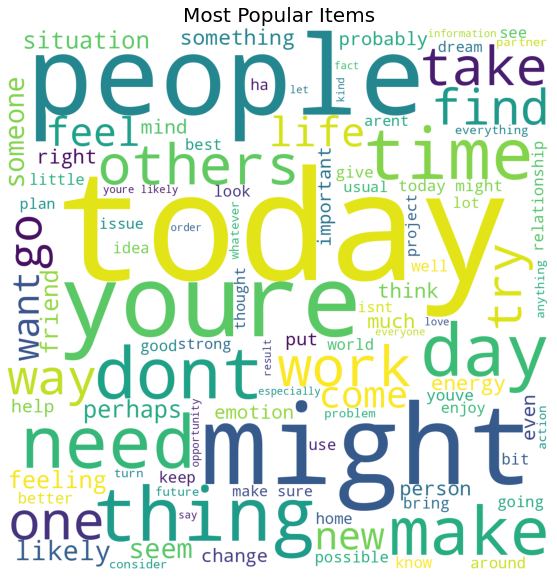

In [31]:
flat_list_all = get_flat_list(preprocess(all_general))
plot_top_words(flat_list_all, collocation_threshold=30, max_words=100)

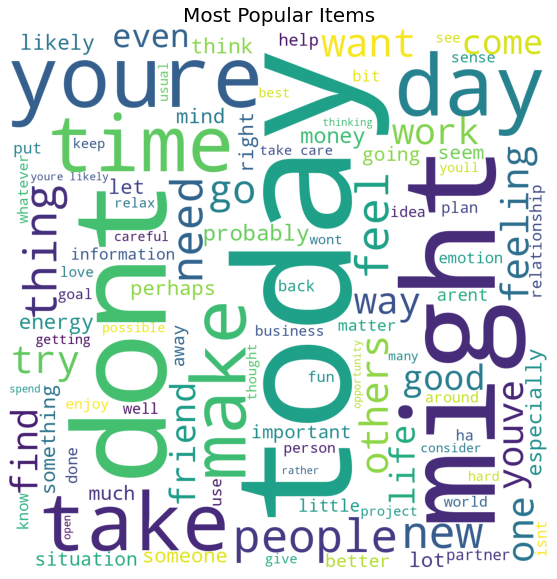

In [ ]:
leo_tokens = preprocess(df[(df['category'] == 'general') & (df['sign'] == 'leo')]['horoscope'])
leo_flat = flat_list(leo_tokens)
plot_top_words(leo_flat, collocation_threshold=30, max_words=100)

In [ ]:
# adapted from https://towardsdatascience.com/the-hottest-topics-in-machine-learning-866ae21ba22d

plt.rcParams['figure.figsize'] = [20, 5] # lengthen

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:100] # edit
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('100 most common words') # edit
    plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# adapted from https://medium.com/swlh/text-summarization-guide-exploratory-data-analysis-on-text-data-4e22ce2dd6ad

# Initialise the count vectorizer
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
# Apply the count vectorized method to our cleaned data
tf = tf_vectorizer.fit_transform(flat_list) # tf_vectorizer.fit_transform(cleaned_text)
# Build the Document Term Matrix
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
# Visualise the 10 most common words
plot_10_most_common_words(tf, tf_vectorizer)

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
# prepare data for wordcloud, list of all tokens
def convert_to_flat_list(tokens):
    return [item for sublist in tokens for item in sublist]

In [36]:
def show_wordcloud(self, wordcloud, sign):
    self.imshow(wordcloud)
    self.set_axis_off()
    self.set_title(sign)

In [41]:
def generate_wordclouds(signs, category, collocation_threshold, max_words):
  wordclouds = []
  tokens_by_sign = []
  for sign in signs:
      sign_tokens = preprocess(df[(df['sign'] == sign) & (df['category'] == category)]['horoscope'])
      tokens_by_sign.append(sign_tokens)
      wordclouds \
        .append(WordCloud(background_color = 'white', width = 200,  height = 200, max_words = max_words, collocation_threshold = collocation_threshold) \
                .generate(remove_punctuation(str(convert_to_flat_list(sign_tokens)))))
  
  fig, ((aries, taurus, gemini), (cancer, leo, virgo), (libra,
       scorpio, sagittarius), (capricorn, aquarius, pisces)) = plt.subplots(4,3, figsize=[20, 20])

  sign_plots = [aries, taurus, gemini, cancer, leo, virgo, libra,
       scorpio, sagittarius, capricorn, aquarius, pisces]

  for i in range(len(sign_plots)):
    show_wordcloud(sign_plots[i], wordclouds[i], signs[i])

  plt.show()

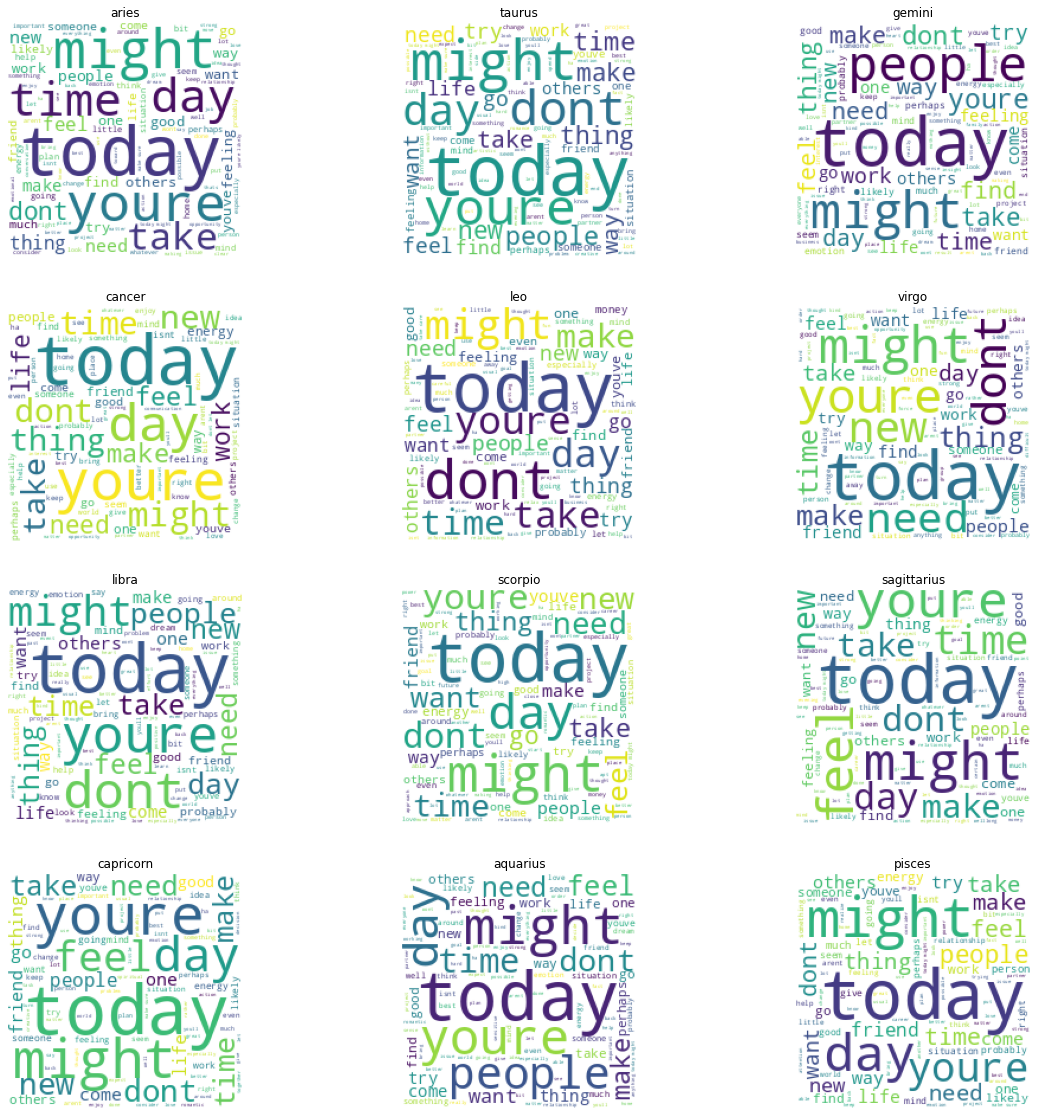

In [42]:
generate_wordclouds(signs, 'general', 30, 100)

In [43]:
# Find patterns by element
def check_elements(df, elements):
    in_elem = np.repeat(False, df.shape[0])
    for sign in elements:
        in_elem = np.vstack((in_elem, df['sign'] == sign))
    return np.any(in_elem, axis = 0)

In [46]:
wordclouds_elements = []
tokens_by_elements = []
element_lists = (fire, water, earth, air)

for element in element_lists:
    sign_tokens = preprocess(df[(check_elements(df, element)) & (df['category'] == 'general')]['horoscope'])
    tokens_by_elements.append(sign_tokens)
    wordclouds_elements.append(WordCloud(background_color = 'white', width = 200,  height = 200, max_words = 100, collocation_threshold=30) \
                               .generate(remove_punctuation(str(convert_to_flat_list(sign_tokens)))))

4



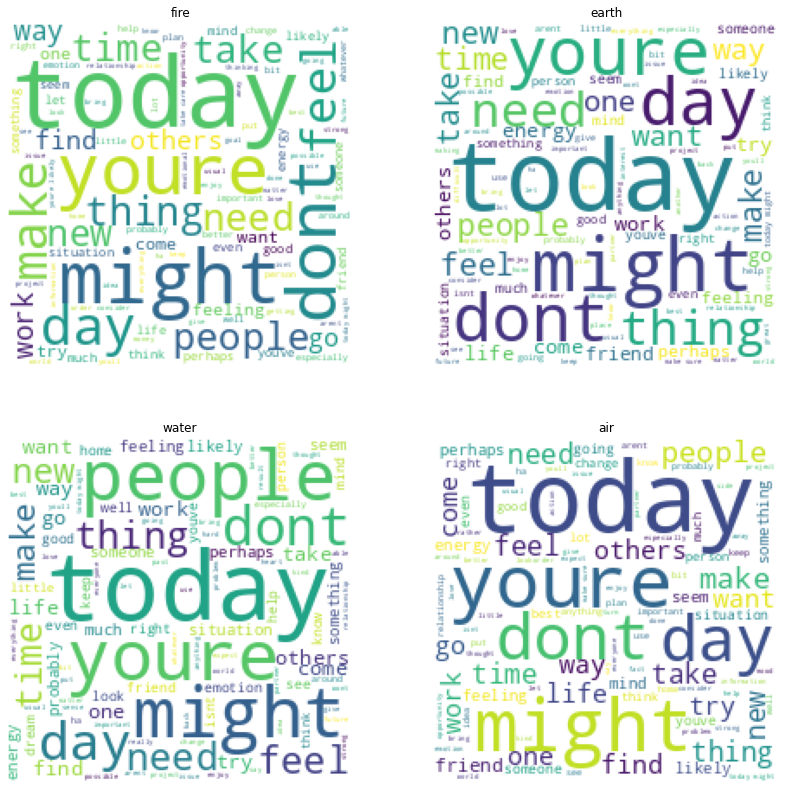

In [47]:
fig, ((fire_ax, water_ax), (air_ax, earth_ax)) = plt.subplots(2,2, figsize=[14, 14])
element_lists = (fire_ax, water_ax, earth_ax, air_ax)
print(len(element_lists))
print()
for i in range(len(element_lists)):
       show_wordcloud(element_lists[i], wordclouds_elements[i], elements[i])

plt.show()

In [55]:
def tfidf_wordclouds(signs, category, max_words):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    wordclouds = []
    for sign in signs:
        vecs = tfidf_vectorizer.fit_transform(df[(df['sign'] == sign) & (df['category'] == category)]['horoscope'])
        feature_names = tfidf_vectorizer.get_feature_names()
        dense = vecs.todense()
        lst1 = dense.tolist()
        cloud_df = pd.DataFrame(lst1, columns=feature_names)
        wordclouds.append(WordCloud(background_color="white", max_words=max_words).generate_from_frequencies(cloud_df.T.sum(axis=1)))

    fig, ((aries, taurus, gemini), (cancer, leo, virgo), (libra,
       scorpio, sagittarius), (capricorn, aquarius, pisces)) = plt.subplots(4,3, figsize=[20, 20])

    sign_plots = [aries, taurus, gemini, cancer, leo, virgo, libra,
       scorpio, sagittarius, capricorn, aquarius, pisces]

    for i in range(len(sign_plots)):
        show_wordcloud(sign_plots[i], wordclouds[i], signs[i])

    plt.show()

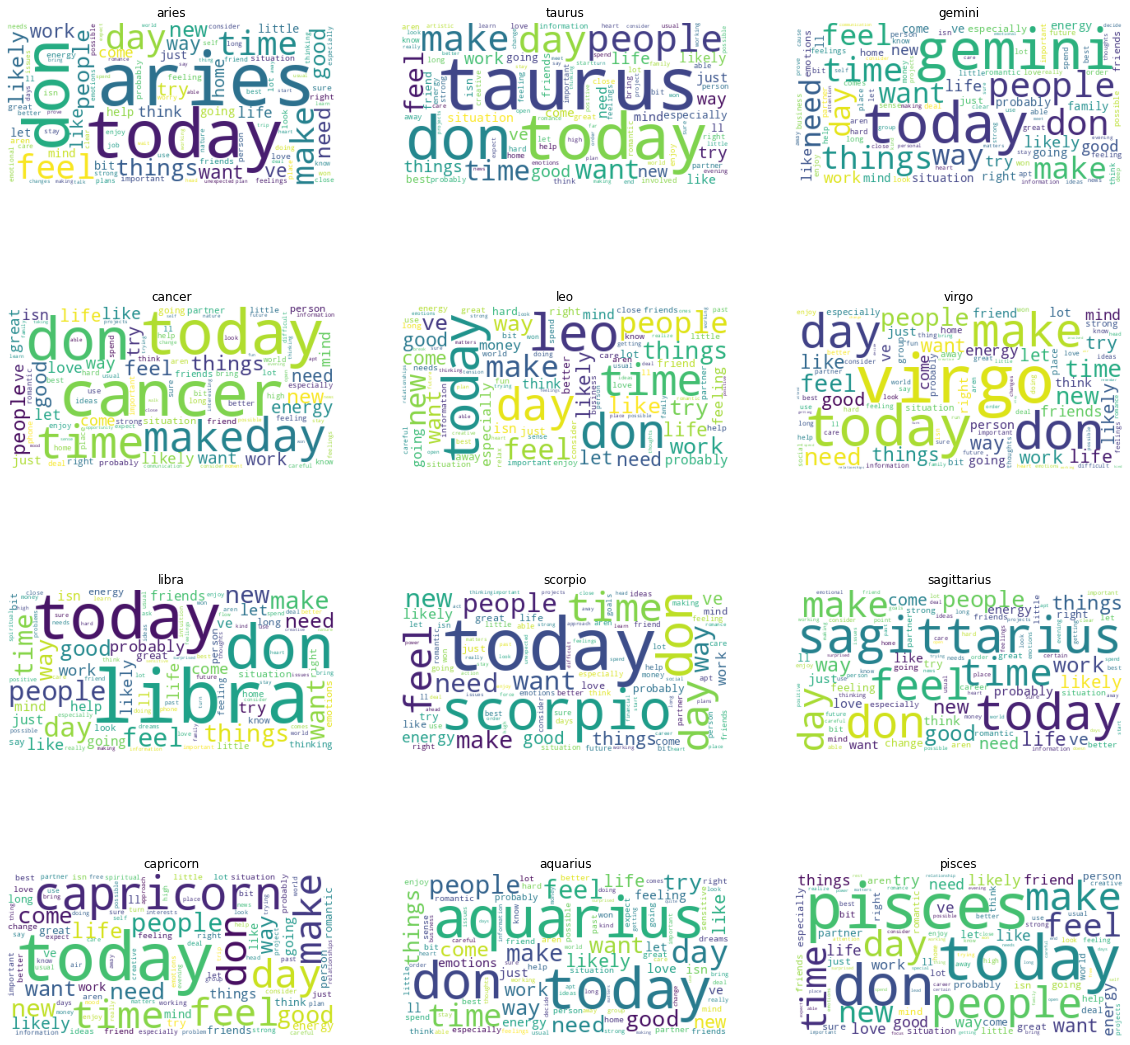

In [56]:
tfidf_wordclouds(signs, 'general', 100)

### Load processed dataset back into csv

In [ ]:
df['processed_tokens'] = preprocess(df['horoscope']) # takes ~3min on all_horoscopes

In [ ]:
# make tokens a string again
df['processed_horoscope'] = [' '.join(map(str, l)) for l in df['processed_tokens']]

In [ ]:
df.to_csv('horoscope_processed.csv')

In [ ]:
from google.colab import files
files.download("horoscope_processed.csv")

In [ ]:
df.head()